<a href="https://colab.research.google.com/github/Rutvikrj26/test/blob/main/DEV_BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde
!pip install numpy
!pip install matplotlib
!pip install tensorflow

In [ ]:
import os
os.environ["DDE_BACKEND"] = "tensorflow.compat.v1"
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
print(f"TensorFlow eager execution: {tf.executing_eagerly()}")  # Should print 'False'

TensorFlow eager execution: False


In [ ]:
"""
2-DOF Aeroelastic Flutter Simulation - Setup Module
---------------------------------------------------
This module contains the basic setup for the aeroelastic flutter simulation using DeepXDE.
"""

# Setup for DeepXDE with TensorFlow 1.x compatibility mode
import os
import numpy as np
import matplotlib.pyplot as plt

# Set DeepXDE backend before importing it
os.environ["DDE_BACKEND"] = "tensorflow.compat.v1"
import tensorflow as tf

# Critical: Disable eager execution for TensorFlow 1.x compatibility
tf.compat.v1.disable_eager_execution()

# Now import DeepXDE
import deepxde as dde

# Print versions for debugging
print(f"DeepXDE version: {dde.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow eager execution: {tf.executing_eagerly()}")

# Simple function to test if DeepXDE is working
def test_deepxde_installation():
    """
    Test if DeepXDE is working correctly with a very simple 1D problem
    Returns True if the test passes, False otherwise
    """
    print("Testing DeepXDE installation with a simple problem...")

    try:
        # Very simple ODE test: u' = 0.5, u(0) = 0
        # (Solution is u(x) = 0.5x)
        def ode(x, y):
            dy_dx = dde.grad.jacobian(y, x)
            return dy_dx - 0.5

        # Domain
        geom = dde.geometry.TimeDomain(0, 1)

        # Initial condition at x=0
        def boundary(x, on_boundary):
            return on_boundary and np.isclose(x[0], 0)

        bc = dde.DirichletBC(geom, lambda x: 0, boundary)

        # Create data
        data = dde.data.PDE(
            geom,
            ode,
            [bc],
            num_domain=10,
            num_boundary=2
        )

        # Very simple network
        net = dde.nn.FNN([1, 5, 1], "tanh", "Glorot uniform")

        # Create model
        model = dde.Model(data, net)

        # Compile and train briefly
        model.compile("adam", lr=0.01)
        model.train(iterations=10)

        # Predict
        x = np.linspace(0, 1, 10)
        y_true = 0.5 * x
        y_pred = model.predict(x.reshape(-1, 1))

        # Compute error
        error = np.mean(np.abs(y_pred.flatten() - y_true))

        print(f"Test completed with mean error: {error:.4f}")
        return error < 0.3  # Pretty loose tolerance

    except Exception as e:
        print(f"DeepXDE test failed with error: {e}")
        import traceback
        traceback.print_exc()
        return False

AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'set_session'

In [ ]:
"""
2-DOF Aeroelastic Flutter Simulation - Aeroelastic Parameters Module
--------------------------------------------------------------------
This module contains the AeroParams class for managing the physical parameters
of the aeroelastic system.
"""

import numpy as np

class AeroParams:
    """
    Class to store and calculate parameters for the 2-DoF aeroelastic flutter model.

    Parameters:
    ----------
    mu : float
        Mass ratio = m/(π*ρ∞*b²)
    r : float
        Radius of gyration = √(Ip/mb²)
    x_theta : float
        Normalized center of mass location
    a : float
        Normalized elastic axis location from mid-chord (-0.5 to 0.5)
    k_h : float
        Plunge spring stiffness (normalized)
    k_theta : float
        Pitch spring stiffness (normalized)
    """
    def __init__(self, mu=20.0, r=0.5, x_theta=0.2, a=-0.4, k_h=1.0, k_theta=1.0):
        self.mu = mu
        self.r = r
        self.x_theta = x_theta
        self.a = a
        self.k_h = k_h
        self.k_theta = k_theta
        self.omega_h = np.sqrt(k_h)
        self.omega_theta = np.sqrt(k_theta)

    def simplified_aero_coefficients(self, velocity):
        """
        Compute simplified aerodynamic coefficients for a given velocity.
        Uses quasi-steady aerodynamics instead of Theodorsen for simplicity.

        Parameters:
        ----------
        velocity : float
            Reduced velocity U* = U/(b*ω_θ)

        Returns:
        -------
        ell_h, ell_theta, m_h, m_theta : float
            Simplified aerodynamic coefficients
        """
        # Simplified quasi-steady aerodynamics (real values only)
        ell_h = 2.0  # Lift due to plunge
        ell_theta = 2.0 * np.pi * (0.5 + self.a)  # Lift due to pitch

        m_h = 2.0 * np.pi * (0.5 + self.a)  # Moment due to plunge
        m_theta = 2.0 * np.pi * (0.5 + self.a)**2  # Moment due to pitch

        return ell_h, ell_theta, m_h, m_theta

    def __str__(self):
        """Return a string representation of the parameters"""
        return (f"AeroParams:\n"
                f"  μ={self.mu} (mass ratio)\n"
                f"  r={self.r} (radius of gyration)\n"
                f"  xθ={self.x_theta} (center of mass)\n"
                f"  a={self.a} (elastic axis)\n"
                f"  kh={self.k_h}, kθ={self.k_theta} (stiffness)")

In [ ]:
"""
2-DOF Aeroelastic Flutter Simulation - Model Creation Module
-----------------------------------------------------------
This module contains functions to create the physics-informed neural network
model for the aeroelastic flutter simulation.
"""

import numpy as np
import deepxde as dde

def create_minimal_flutter_model(velocity, params, time_domain=(0, 3), num_domain=50):
    """
    Create a minimal PINN model for the 2-DoF aeroelastic flutter problem

    Parameters:
    ----------
    velocity : float
        Dimensionless flow velocity U* = U/(b*ω_θ)
    params : AeroParams
        Object containing system parameters
    time_domain : tuple
        (t_min, t_max) for the time domain
    num_domain : int
        Number of training points in the domain

    Returns:
    -------
    model : dde.Model
        DeepXDE model for the flutter problem
    """
    # Create time domain
    geom = dde.geometry.TimeDomain(time_domain[0], time_domain[1])

    # Get simplified aerodynamic coefficients
    ell_h, ell_theta, m_h, m_theta = params.simplified_aero_coefficients(velocity)

    # Define the PDE system
    def pde(t, y):
        """
        Define the PDEs for the flutter system
        t: time variable
        y: [h, theta, h_dot, theta_dot]
        """
        # Extract solution components
        h = y[:, 0:1]         # Plunge displacement
        theta = y[:, 1:2]     # Pitch angle
        h_dot = y[:, 2:3]     # Plunge velocity
        theta_dot = y[:, 3:4] # Pitch velocity

        # Compute the time derivatives using auto-differentiation
        h_t = dde.grad.jacobian(y, t, i=0)
        theta_t = dde.grad.jacobian(y, t, i=1)
        h_dot_t = dde.grad.jacobian(y, t, i=2)    # h_tt (acceleration)
        theta_dot_t = dde.grad.jacobian(y, t, i=3) # theta_tt (angular acceleration)

        # Equations of motion (from 5.62 in the textbook)
        # For plunge (h)
        eq1 = (params.mu * h_dot_t +
               params.mu * params.x_theta * theta_dot_t +
               params.k_h * h +
               velocity**2 * ell_h * h +
               velocity**2 * ell_theta * theta)

        # For pitch (theta)
        eq2 = (params.mu * params.x_theta * h_dot_t +
               params.mu * params.r**2 * theta_dot_t +
               params.k_theta * theta +
               velocity**2 * m_h * h +
               velocity**2 * m_theta * theta)

        # First-order system equations
        eq3 = h_dot - h_t
        eq4 = theta_dot - theta_t

        return [eq1, eq2, eq3, eq4]

    # Initial conditions at t=0
    def boundary_t0(x, on_boundary):
        return on_boundary and np.isclose(x[0], time_domain[0])

    # Set initial conditions directly with constant values to avoid auxiliary variable issues
    bc1 = dde.DirichletBC(geom, lambda x: 0.01, boundary_t0, component=0)  # h(0) = 0.01
    bc2 = dde.DirichletBC(geom, lambda x: 0.0, boundary_t0, component=1)   # θ(0) = 0
    bc3 = dde.DirichletBC(geom, lambda x: 0.0, boundary_t0, component=2)   # h'(0) = 0
    bc4 = dde.DirichletBC(geom, lambda x: 0.0, boundary_t0, component=3)   # θ'(0) = 0

    # Create the data
    data = dde.data.PDE(
        geom,
        pde,
        [bc1, bc2, bc3, bc4],
        num_domain=num_domain,
        num_boundary=4,  # One point for each initial condition
        solution=None    # No analytical solution
    )

    # Define a very simple neural network
    net = dde.nn.FNN(
        [1, 5, 5, 4],    # 1 input, 2 hidden layers with 5 neurons, 4 outputs
        "tanh",          # Activation function
        "Glorot uniform" # Weight initialization
    )

    # Create the model
    model = dde.Model(data, net)

    return model

In [ ]:
"""
2-DOF Aeroelastic Flutter Simulation - Training and Visualization Module
-----------------------------------------------------------------------
This module contains functions for training the model and visualizing results.
"""

import numpy as np
import matplotlib.pyplot as plt

def train_minimal_model(model, iterations=50, learning_rate=0.01):
    """
    Train the PINN model with minimal settings

    Parameters:
    ----------
    model : dde.Model
        DeepXDE model to train
    iterations : int
        Number of training iterations
    learning_rate : float
        Learning rate for Adam optimizer

    Returns:
    -------
    model : dde.Model
        Trained model
    losses : list
        Training losses
    """
    # Configure the model with Adam optimizer
    print(f"Compiling model with learning rate: {learning_rate}")
    model.compile("adam", lr=learning_rate)

    # Train with minimal iterations
    print(f"Training for {iterations} iterations...")
    try:
        losshistory, train_state = model.train(iterations=iterations)
        losses = losshistory.loss_train
        print(f"Training completed with final loss: {losses[-1]:.6f}")
    except Exception as e:
        print(f"Warning: Training encountered an error: {e}")
        print("Returning model with partial training.")
        losses = []

    return model, losses

def predict_and_visualize(model, time_domain=(0, 3), num_points=50):
    """
    Generate predictions and visualize the results

    Parameters:
    ----------
    model : dde.Model
        Trained DeepXDE model
    time_domain : tuple
        (t_min, t_max) for prediction
    num_points : int
        Number of prediction points

    Returns:
    -------
    fig : matplotlib.figure.Figure
        Figure with visualization
    """
    # Generate time points for prediction
    t_pred = np.linspace(time_domain[0], time_domain[1], num_points)

    # Make predictions
    print("Generating predictions...")
    try:
        y_pred = model.predict(t_pred.reshape(-1, 1))

        # Extract solutions
        h_pred = y_pred[:, 0]       # Plunge
        theta_pred = y_pred[:, 1]   # Pitch
        h_dot_pred = y_pred[:, 2]   # Plunge velocity
        theta_dot_pred = y_pred[:, 3] # Pitch velocity

        # Create figure with 2x2 subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))

        # Plot plunge displacement
        axs[0, 0].plot(t_pred, h_pred)
        axs[0, 0].set_title("Plunge (h/b)")
        axs[0, 0].set_xlabel("Time")
        axs[0, 0].grid(True)

        # Plot pitch angle
        axs[0, 1].plot(t_pred, theta_pred)
        axs[0, 1].set_title("Pitch (θ)")
        axs[0, 1].set_xlabel("Time")
        axs[0, 1].grid(True)

        # Plot plunge velocity
        axs[1, 0].plot(t_pred, h_dot_pred)
        axs[1, 0].set_title("Plunge Velocity (ḣ)")
        axs[1, 0].set_xlabel("Time")
        axs[1, 0].grid(True)

        # Plot pitch velocity
        axs[1, 1].plot(t_pred, theta_dot_pred)
        axs[1, 1].set_title("Pitch Velocity (θ̇)")
        axs[1, 1].set_xlabel("Time")
        axs[1, 1].grid(True)

        plt.tight_layout()

        return fig

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

=== 2-DOF Aeroelastic Flutter Simulation using DeepXDE ===
This is an ultra-minimal implementation for demonstration.
Testing DeepXDE installation with a simple problem...
Compiling model...
Building feed-forward neural network...
'build' took 0.054029 s

'compile' took 0.579570 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.69e-01, 0.00e+00]    [5.69e-01, 0.00e+00]    []  
10        [1.13e-01, 5.28e-03]    [1.13e-01, 5.28e-03]    []  

Best model at step 10:
  train loss: 1.18e-01
  test loss: 1.18e-01
  test metric: []

'train' took 2.108198 s

Test completed with mean error: 0.2495

DeepXDE is working correctly. Starting flutter simulation...
AeroParams:
  μ=10.0 (mass ratio)
  r=0.5 (radius of gyration)
  xθ=0.2 (center of mass)
  a=-0.4 (elastic axis)
  kh=1.0, kθ=1.0 (stiffness)

Simulating at velocity U* = 2.0...
Compiling model with learning rate: 0.01
Compiling model...
Building feed-forward neural network...
'build' to

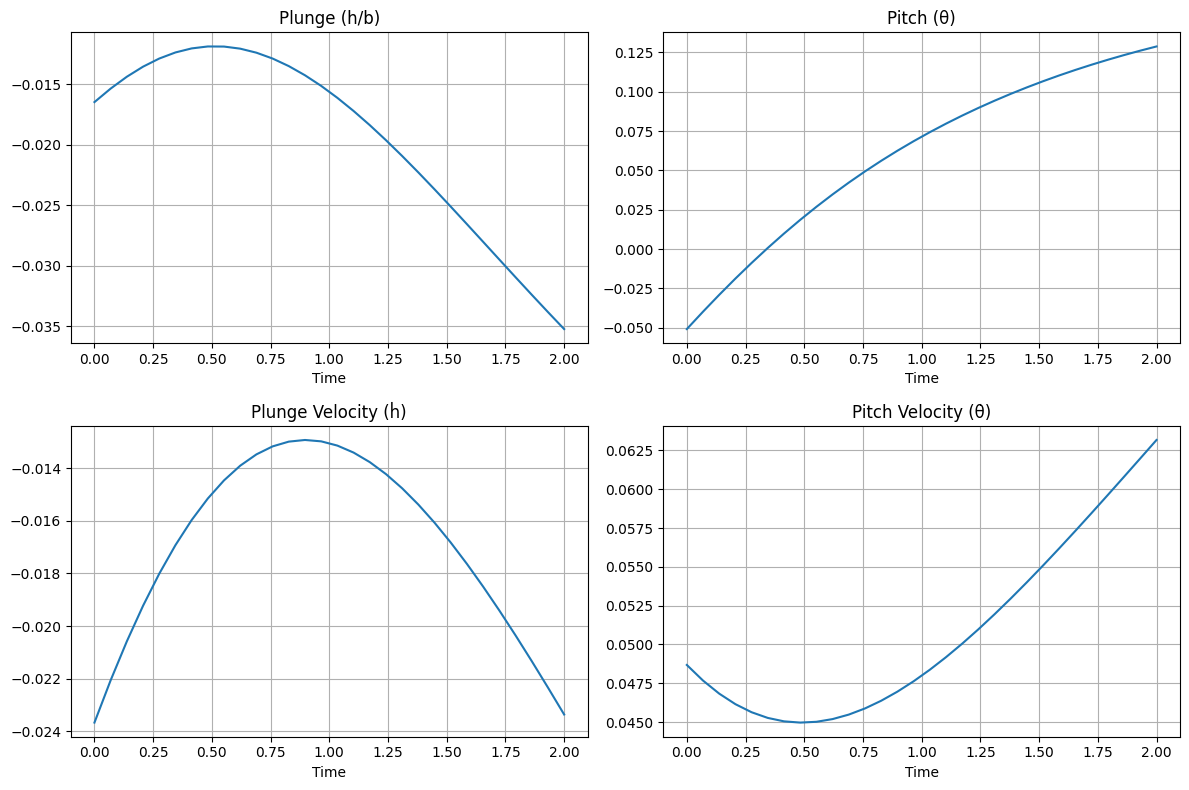


Simulation completed successfully!

To investigate flutter behavior:
1. Try different velocities (increase until flutter occurs)
2. Increase training iterations (500+) for better accuracy
3. Extend the time domain to see long-term behavior
4. Use a more complex neural network


In [ ]:
"""
2-DOF Aeroelastic Flutter Simulation - Main Script
-------------------------------------------------
This script runs the 2-DoF aeroelastic flutter simulation using DeepXDE.
"""

import matplotlib.pyplot as plt

def main():
    """
    Main function to run the flutter simulation
    """
    print("=== 2-DOF Aeroelastic Flutter Simulation using DeepXDE ===")
    print("This is an ultra-minimal implementation for demonstration.")

    # First check if DeepXDE is working properly
    if not test_deepxde_installation():
        print("DeepXDE installation test failed. Please check your setup.")
        return

    print("\nDeepXDE is working correctly. Starting flutter simulation...")

    # Set up aeroelastic parameters with simplified values for demo
    params = AeroParams(
        mu=10.0,      # Mass ratio
        r=0.5,        # Radius of gyration
        x_theta=0.2,  # Center of mass location
        a=-0.4,       # Elastic axis location
        k_h=1.0,      # Plunge spring stiffness
        k_theta=1.0   # Pitch spring stiffness
    )

    print(params)

    # Define flow velocity to test (below flutter speed for stability)
    velocity = 2.0
    print(f"\nSimulating at velocity U* = {velocity}...")

    try:
        # Create a minimal model
        model = create_minimal_flutter_model(
            velocity=velocity,
            params=params,
            time_domain=(0, 2),  # Very short time domain
            num_domain=40        # Very few training points
        )

        # Train the model with minimal settings
        trained_model, losses = train_minimal_model(
            model=model,
            iterations=50,       # Very few iterations
            learning_rate=0.01   # Higher learning rate
        )

        # Generate predictions and visualize
        fig = predict_and_visualize(
            model=trained_model,
            time_domain=(0, 2),
            num_points=30
        )

        if fig:
            plt.show()
            print("\nSimulation completed successfully!")

            # Add next steps guidance
            print("\nTo investigate flutter behavior:")
            print("1. Try different velocities (increase until flutter occurs)")
            print("2. Increase training iterations (500+) for better accuracy")
            print("3. Extend the time domain to see long-term behavior")
            print("4. Use a more complex neural network")

    except Exception as e:
        print(f"\nError during simulation: {e}")
        import traceback
        traceback.print_exc()

        print("\nTroubleshooting tips:")
        print("1. Try a simpler neural network architecture")
        print("2. Reduce the time domain further")
        print("3. Reduce the number of domain points")
        print("4. Check GPU memory usage")

if __name__ == "__main__":
    main()

DeepXDE version: 1.13.2
TensorFlow version: 2.18.0
TensorFlow eager execution: False
=== 2-DOF Aeroelastic Flutter Simulation using DeepXDE ===
This is an ultra-minimal implementation for demonstration.
Testing DeepXDE installation with a simple problem...
Compiling model...
Building feed-forward neural network...
'build' took 0.031339 s

'compile' took 0.526392 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.69e-01, 0.00e+00]    [5.69e-01, 0.00e+00]    []  
10        [1.13e-01, 5.28e-03]    [1.13e-01, 5.28e-03]    []  

Best model at step 10:
  train loss: 1.18e-01
  test loss: 1.18e-01
  test metric: []

'train' took 2.936729 s

Test completed with mean error: 0.2495

DeepXDE is working correctly. Starting flutter simulation...
AeroParams:
  μ=10.0 (mass ratio)
  r=0.5 (radius of gyration)
  xθ=0.2 (center of mass)
  a=-0.4 (elastic axis)
  kh=1.0, kθ=1.0 (stiffness)

Simulating at velocity U* = 2.0...
Compiling model with lear

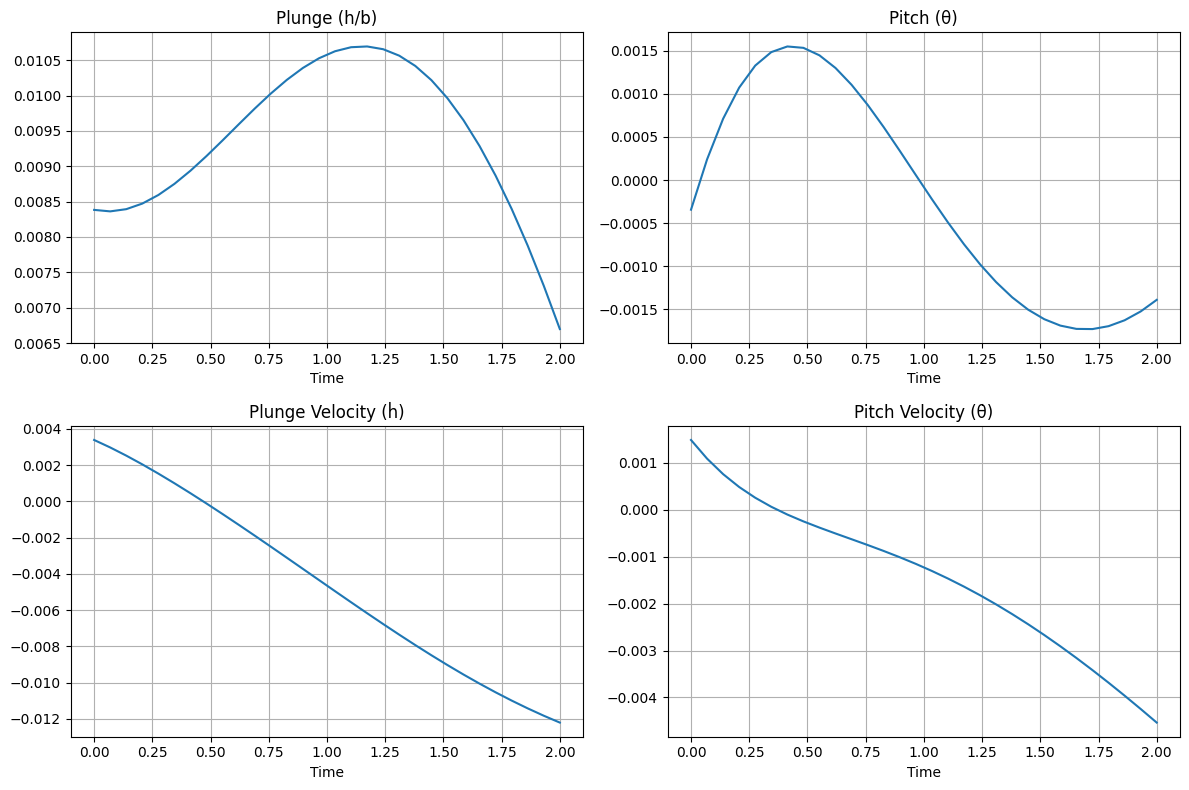


Simulation completed successfully!

To investigate flutter behavior:
1. Try different velocities (increase until flutter occurs)
2. Increase training iterations (500+) for better accuracy
3. Extend the time domain to see long-term behavior
4. Use a more complex neural network
